# The Goal

The goal of this notebook is to explore the possibilities of usage of Support Vector Machines. In order to do this I will use datasets: Iris, MNIST and California housing.

In [1]:
from sklearn import datasets
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import f1_score

In [2]:
# Wymagane środowisko Python ≥3.5
import sys
assert sys.version_info >= (3, 5)
import math, time, random, datetime

# Wymagana biblioteka Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Importuje standardowe biblioteki
import numpy as np
import os
import pandas as pd

# Aby wyniki uzyskiwane w tym notatniku były odtwarzalne
np.random.seed(42)

# Do rysowania ładnych wykresów
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # długość płatka, szerokość płatka
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
SupportVectorCLF = SVC(kernel="linear", C=5, gamma='auto')
SupportVectorCLF.fit(X_scaled, y)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [5]:
LinearSupportVectorCLF = LinearSVC(loss="hinge", C=5, random_state=42)
LinearSupportVectorCLF.fit(X_scaled, y)

LinearSVC(C=5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=42, tol=0.0001, verbose=0)

In [6]:
SGDCLF = SGDClassifier(alpha = 1, max_iter=1000, tol=1e-3)
SGDCLF.fit(X_scaled, y)

SGDClassifier(alpha=1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='hinge', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [7]:
print("LinearSVC:                   ", LinearSupportVectorCLF.intercept_, LinearSupportVectorCLF.coef_)
print("SVC:                         ", SupportVectorCLF.intercept_, SupportVectorCLF.coef_)
print("SGDClassifier(alpha={:.5f}):".format(SGDCLF.alpha), SGDCLF.intercept_, SGDCLF.coef_)

LinearSVC:                    [0.28474027] [[1.0536456  1.09903032]]
SVC:                          [0.31896852] [[1.1203284  1.02625193]]
SGDClassifier(alpha=1.00000): [-0.03230744] [[0.49232576 0.46726301]]


In [8]:
LinearSupportVectorCLF.coef_[0, 0]

1.0536456048627372

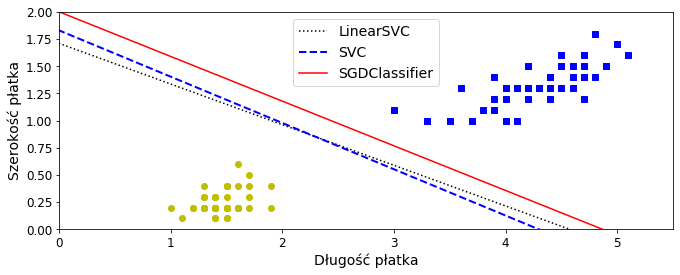

In [9]:
# Oblicza nachylenie i obciążenie każdej granicy decyzyjnej
w1 = -LinearSupportVectorCLF.coef_[0, 0]/LinearSupportVectorCLF.coef_[0, 1]
b1 = -LinearSupportVectorCLF.intercept_[0]/LinearSupportVectorCLF.coef_[0, 1]
w2 = -SupportVectorCLF.coef_[0, 0]/SupportVectorCLF.coef_[0, 1]
b2 = -SupportVectorCLF.intercept_[0]/SupportVectorCLF.coef_[0, 1]
w3 = -SGDCLF.coef_[0, 0]/SGDCLF.coef_[0, 1]
b3 = -SGDCLF.intercept_[0]/SGDCLF.coef_[0, 1]

# Przekształca linie granic decyzyjnych z powrotem do pierwotnej skali
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# Generuje wykres wszystkich trzech granic decyzyjnych
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Długość płatka", fontsize=14)
plt.ylabel("Szerokość płatka", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

## Testing SVM on Titanic DataSet

In [10]:
titanic_dataset = pd.read_csv("data_after_eda.csv")

selected_data = titanic_dataset.copy()
survived = selected_data["Survived"].copy()
selected_data = selected_data.drop(['Survived'], axis=1)
selected_data_scaled = scaler.fit_transform(selected_data)

X_train, X_test, Y_train, Y_test = selected_data[:700], selected_data[700:], survived[:700], survived[700:]
X_train_scaled, X_test_scaled = selected_data_scaled[:700], selected_data_scaled[700]

### SVC

According to the documentation:
- implementation is based on libsvm
- handles different types of kernels (linear, rbf, poly etc)
- may be impractical beyond tens of thousands of samples - not great for large datasets

In [11]:
def fit_check_cross_val_score(algorithm, X_train, X_test, Y_train, Y_test):
    accuracy = cross_val_score(algorithm, X_train, Y_train, cv=3, scoring='accuracy')
    accuracy = np.sum(accuracy)/3
    
    y_train_pred = cross_val_predict(algorithm, X_train, Y_train, cv=3)
    f1 = f1_score(Y_train, y_train_pred)
    print("Accuracy: %s" % accuracy)
    print("F1 Score: %s" % f1)
    return accuracy, f1

In [12]:
start_time = time.time()
svc_linear_acc, svc_linear_f1 = fit_check_cross_val_score(SVC(kernel="linear"), X_train, X_test, Y_train, Y_test)
end_time_svc_linear = (time.time() - start_time)

Accuracy: 0.7856950711027965
F1 Score: 0.7126436781609196


In [13]:
start_time = time.time()
svc_rbf_acc, svc_rbf_f1 = fit_check_cross_val_score(SVC(C=10, kernel="rbf", gamma='auto'), X_train, X_test, Y_train, Y_test)
end_time_rbf = (time.time() - start_time)

Accuracy: 0.7443172786520426
F1 Score: 0.6524271844660194


In [14]:
start_time = time.time()
svc_linear_scaled_acc, svc_linear_scaled_f1 = fit_check_cross_val_score(SVC(C=1, kernel="linear"), X_train_scaled, X_test_scaled, Y_train, Y_test)
end_time_svc_linear_scaled = (time.time() - start_time)

Accuracy: 0.7856950711027965
F1 Score: 0.7126436781609196


In [15]:
start_time = time.time()
svc_rbf_scaled_acc, svc_rbf_scaled_f1 = fit_check_cross_val_score(SVC(C=1, kernel="rbf", gamma='auto'), X_train_scaled, X_test_scaled, Y_train, Y_test)
end_time_svc_rbf_scaled = (time.time() - start_time)

Accuracy: 0.8028685668170646
F1 Score: 0.7063829787234043


### LinearSVC

In [16]:
start_time = time.time()
linearSVC_acc, linearSVC_f1 = fit_check_cross_val_score(LinearSVC(), X_train, X_test, Y_train, Y_test)
end_time_svc_linear = (time.time() - start_time)

Accuracy: 0.7857072985828352
F1 Score: 0.7029126213592233


C:\Users\serwis\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\serwis\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\serwis\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\serwis\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\serwis\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

In [17]:
start_time = time.time()
linearSVC_scaled_acc, linearSVC_scaled_f1 = fit_check_cross_val_score(LinearSVC(), X_train_scaled, X_test_scaled, Y_train, Y_test)
end_time_LinearSVC_scaled = (time.time() - start_time)

C:\Users\serwis\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\serwis\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.784270569678295
F1 Score: 0.7070312499999999


C:\Users\serwis\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\serwis\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\serwis\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\serwis\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## SGDClassifier

In [18]:
start_time = time.time()
sgdclassifier_acc, sgdclassifier_f1 = fit_check_cross_val_score(SGDClassifier(), X_train, X_test, Y_train, Y_test)
end_time_sgdclassifier = (time.time() - start_time)

Accuracy: 0.670041451157331
F1 Score: 0.5894736842105264


In [19]:
start_time = time.time()
sgdclassifier_scaled_acc, sgdclassifier_scaled_f1 = fit_check_cross_val_score(SGDClassifier(), X_train_scaled, X_test_scaled, Y_train, Y_test)
end_time_sgdclassifier_scaled = (time.time() - start_time)

Accuracy: 0.7871256862673172
F1 Score: 0.6058252427184466


# Comparing Results

In [20]:
acc = pd.DataFrame({
    'Model': ['svc linear','svc rbf','svc linear scaled', 
             'svc rbf scaled', 'LinearSVC', 'LinearSVC scaled',
             'SGDClassifier', 'SGDClassifier scaled'],
    'Score': [svc_linear_acc, 
              svc_rbf_acc,
              svc_linear_scaled_acc,
              svc_rbf_scaled_acc,
              linearSVC_acc,
              linearSVC_scaled_acc,
              sgdclassifier_acc,
              sgdclassifier_scaled_acc
    ]})
print("--- Accuracy Scores---")
acc.sort_values(by='Score', ascending=False)

--- Accuracy Scores---


,Model,Score
3,svc rbf scaled,0.802869
7,SGDClassifier scaled,0.787126
4,LinearSVC,0.785707
0,svc linear,0.785695
2,svc linear scaled,0.785695
5,LinearSVC scaled,0.784271
1,svc rbf,0.744317
6,SGDClassifier,0.670041


In [21]:
acc = pd.DataFrame({
    'Model': ['svc linear','svc rbf','svc linear scaled', 
             'svc rbf scaled', 'LinearSVC', 'LinearSVC scaled',
             'SGDClassifier', 'SGDClassifier scaled'],
    'Score': [svc_linear_f1, 
              svc_rbf_f1,
              svc_linear_scaled_f1,
              svc_rbf_scaled_f1,
              linearSVC_f1,
              linearSVC_scaled_f1,
              sgdclassifier_f1,
              sgdclassifier_scaled_f1
    ]})
print("--- F1 ---")
acc.sort_values(by='Score', ascending=False)

--- F1 ---


,Model,Score
0,svc linear,0.712644
2,svc linear scaled,0.712644
5,LinearSVC scaled,0.707031
3,svc rbf scaled,0.706383
4,LinearSVC,0.702913
1,svc rbf,0.652427
7,SGDClassifier scaled,0.605825
6,SGDClassifier,0.589474


In [22]:
acc = pd.DataFrame({
    'Model': ['svc linear','svc rbf','svc linear scaled', 
             'svc rbf scaled', 'LinearSVC', 'LinearSVC scaled',
             'SGDClassifier', 'SGDClassifier scaled'],
    'Score': [end_time_svc_linear, 
              end_time_rbf,
              end_time_svc_linear_scaled,
              end_time_svc_rbf_scaled,
              end_time_LinearSVC,
              end_time_LinearSVC_scaled,
              end_time_sgdclassifier,
              end_time_sgdclassifier_scaled
    ]})
print("--- Accuracy F1---")
acc.sort_values(by='Score', ascending=False)

NameError: name 'end_time_LinearSVC' is not defined